# 1. Import libraries

In [1]:
#----------------------------Reproducible----------------------------------------------------------------------------------------
import numpy as np
import tensorflow as tf
import random as rn
import os

seed=0
os.environ['PYTHONHASHSEED'] = str(seed)

np.random.seed(seed)
rn.seed(seed)
#session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
session_conf =tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

from keras import backend as K

#tf.set_random_seed(seed)
tf.compat.v1.set_random_seed(seed)
#sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)

K.set_session(sess)
#----------------------------Reproducible----------------------------------------------------------------------------------------

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

#--------------------------------------------------------------------------------------------------------------------------------
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Dense, Input, Flatten, Activation, Dropout, Layer
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical,plot_model
from keras import optimizers,initializers,constraints,regularizers
from keras import backend as K
from keras.callbacks import LambdaCallback,ModelCheckpoint
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier
from sklearn import svm
from sklearn.model_selection import cross_val_score,ShuffleSplit,train_test_split,StratifiedKFold
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler,LabelEncoder,OneHotEncoder
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from skimage import io
from PIL import Image
import scipy.sparse as sparse
import pandas as pd
import random
import h5py
import math
import gc
from functools import reduce
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mlxtend.plotting import plot_confusion_matrix

%matplotlib inline
matplotlib.style.use('ggplot')

#--------------------------------------------------------------------------------------------------------------------------------
#Import ourslef defined methods
import sys
sys.path.append(r"./Defined")
import Functions as F

/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

# 2. Parameters

In [2]:
original_edge_length=28
original_edge_width=28

number_samples_for_show=30

minority=20
majority=380
sampling_times=100
seed_range=np.random.randint(100,size=100)#np.arange(0,100,1)
p_n_estimators=150

# 3. Import data

## 3.1 Loading data

In [3]:
Samples_Used=np.array([1,9])
Sample_numbers=np.array([380,20])
Total_numbers=np.sum(Sample_numbers)

(X, y_), (_, _) = mnist.load_data()

X_=X.reshape(60000, 28*28).astype('float32') / 255.

In [4]:
MNISTSamples=[]
MNISTLabels=[]
for i in np.arange(len(Samples_Used)):
    print(i)
    number=Samples_Used[i]
    Sample=Sample_numbers[i]
    Get_Index=np.where(y_==number)[0][0:Sample]
    Get_Label=y_[Get_Index]
    MNISTLabels.append(Get_Label)
    Get_Sample=X_[Get_Index]
    MNISTSamples.append(Get_Sample)

0
1


In [5]:
Labels=np.concatenate(MNISTLabels)
Array_Feature=np.concatenate(MNISTSamples)

rand_indices = np.random.permutation(Total_numbers)

Array_Feature_=np.array(Array_Feature)[rand_indices]
Labels_=np.array(Labels)[rand_indices]

## 3.2 The number of samples for different classes

In [6]:
for i in Samples_Used:
    print(i,":",np.sum(Labels_==i))

1 : 380
9 : 20


## 3.3 Do undersampling and generate multiple sample subsets

In [7]:
Samples_list=[]
Labels_for_Samples_list=[]
for time_i in np.arange(sampling_times):
    seed_i=time_i
    rus=RandomUnderSampler(sampling_strategy={1: majority,9:minority},random_state=seed_i,replacement=True)
    Samples_,Labels_for_Samples_=rus.fit_sample(Array_Feature_,Labels_)
    Samples_list.append(Samples_)
    Labels_for_Samples_list.append(Labels_for_Samples_)

## 3.5 Split training and testing samples

In [8]:
X_train_list=[]
X_test_list=[]
y_train_list=[]
y_test_list=[]

for time_i in np.arange(sampling_times):
    Samples_list_i_=Samples_list[time_i]
    Labels_for_Samples_i_=Labels_for_Samples_list[time_i]
    rand_indices = np.random.permutation(majority+minority)
    Samples_list_i=Samples_list_i_[rand_indices]
    Labels_for_Samples_i=Labels_for_Samples_i_[rand_indices]
    
    X_train_i,X_test_i, y_train_i, y_test_i =train_test_split(Samples_list_i,Labels_for_Samples_i,test_size=0.3, random_state=seed)

    print('Shape of X_train_i: ' + str(X_train_i.shape))
    print('Shape of y_train_i: ' + str(y_train_i.shape))
    print('Shape of X_test_i: ' + str(X_test_i.shape))
    print('Shape of y_test_i: ' + str(y_test_i.shape))
    
    X_train_list.append(X_train_i)
    X_test_list.append(X_test_i)
    y_train_list.append(y_train_i)
    y_test_list.append(y_test_i)
    
    print("\n======================================================\n\n")

Shape of X_train_i: (280, 784)
Shape of y_train_i: (280,)
Shape of X_test_i: (120, 784)
Shape of y_test_i: (120,)



Shape of X_train_i: (280, 784)
Shape of y_train_i: (280,)
Shape of X_test_i: (120, 784)
Shape of y_test_i: (120,)



Shape of X_train_i: (280, 784)
Shape of y_train_i: (280,)
Shape of X_test_i: (120, 784)
Shape of y_test_i: (120,)



Shape of X_train_i: (280, 784)
Shape of y_train_i: (280,)
Shape of X_test_i: (120, 784)
Shape of y_test_i: (120,)



Shape of X_train_i: (280, 784)
Shape of y_train_i: (280,)
Shape of X_test_i: (120, 784)
Shape of y_test_i: (120,)



Shape of X_train_i: (280, 784)
Shape of y_train_i: (280,)
Shape of X_test_i: (120, 784)
Shape of y_test_i: (120,)



Shape of X_train_i: (280, 784)
Shape of y_train_i: (280,)
Shape of X_test_i: (120, 784)
Shape of y_test_i: (120,)



Shape of X_train_i: (280, 784)
Shape of y_train_i: (280,)
Shape of X_test_i: (120, 784)
Shape of y_test_i: (120,)



Shape of X_train_i: (280, 784)
Shape of y_train_i: (280,)
Shape 

## 3.6 Display training and testing samples

./Defined/Functions.py:71: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  plt.tight_layout(p_pad,p_w_pad, p_h_pad)


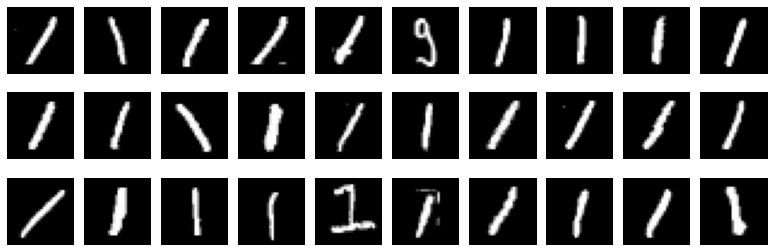

In [9]:
F.show_data_figures(np.array(X_train_list[0])[0:number_samples_for_show,:],original_edge_width,original_edge_length,columns = 10,p_pad=-2,p_w_pad=0.15, p_h_pad=1)

In [10]:
y_train_list[0][0:number_samples_for_show]

array([1, 1, 1, 1, 1, 9, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1], dtype=uint8)

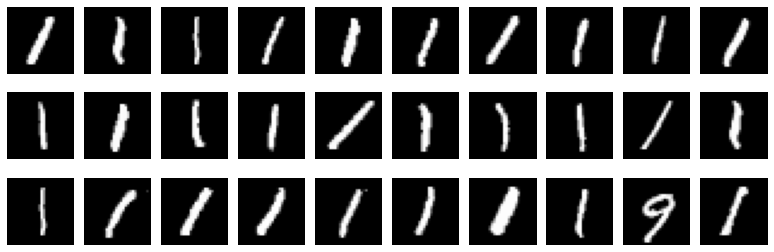

In [11]:
F.show_data_figures(np.array(X_train_list[1])[0:number_samples_for_show,:],original_edge_width,original_edge_length,columns = 10,p_pad=-2,p_w_pad=0.15, p_h_pad=1)

In [12]:
y_train_list[1][0:number_samples_for_show]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 9, 1], dtype=uint8)

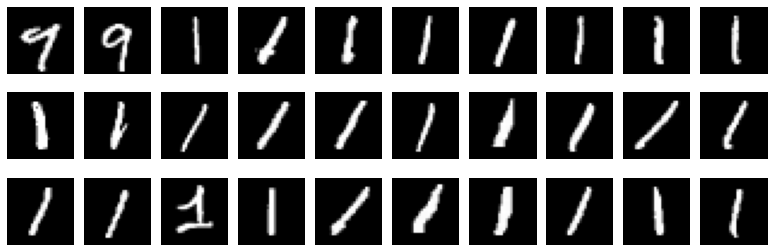

In [13]:
F.show_data_figures(np.array(X_test_list[0])[0:number_samples_for_show,:],original_edge_width,original_edge_length,columns = 10,p_pad=-2,p_w_pad=0.15, p_h_pad=1)

In [14]:
y_test_list[0][0:number_samples_for_show]

array([9, 9, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1], dtype=uint8)

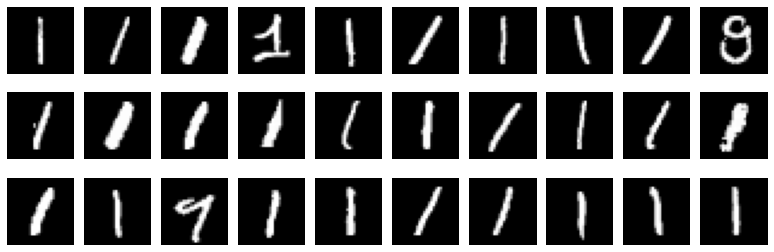

In [15]:
F.show_data_figures(np.array(X_test_list[1])[0:number_samples_for_show,:],original_edge_width,original_edge_length,columns = 10,p_pad=-2,p_w_pad=0.15, p_h_pad=1)

In [16]:
y_train_list[1][0:number_samples_for_show]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 9, 1], dtype=uint8)

# 4 Analysis

## 4.1 Improt predicated results

In [17]:
path_predicated_results="./RF_results/MNIST19_predicated_results_2L.csv"
predicated_results=pd.read_csv(path_predicated_results, sep='delimiter', header=None)
class_names=["1","9"]

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


## 4.2 Average accuarcy and confusion matrix

In [18]:
time_i=int(predicated_results.shape[0]/(4*len(seed_range)))
print("The number of samplings: ",time_i)

Acc_train_ave_collect=[]
Acc_test_ave_collect=[]
conf_martix_ave_collect=[]
report_matrix_ave_collect=[]

for time_i in np.arange(time_i):
    print("Sampling "+str(time_i+1)+"----------------------------------------------------------------------------------\n")
    
    Acc_train_list=[]
    Acc_test_list=[]

    conf_martix=[]
    report_matrix=[]

    for pred_i in np.arange(len(seed_range)*time_i,len(seed_range)*(time_i+1)):
    
        Acc_train=np.array(predicated_results)[4*pred_i]
        Acc_test=np.array(predicated_results)[4*pred_i+1]
        p_y_pred=np.array(predicated_results)[4*pred_i+2]
        p_y_test=np.array(predicated_results)[4*pred_i+3]
        
        Acc_train_list.append(Acc_train)
        Acc_test_list.append(Acc_test)
    
        pred_set=np.array(p_y_pred[0].split(",")).astype(float)
        truth_set=np.array(p_y_test[0].split(",")).astype(float)

        conf_martix_i = np.array(confusion_matrix(truth_set, pred_set))
        conf_martix.append(conf_martix_i)

        report = classification_report(truth_set, pred_set)
        report_matrix_i=[]
        report_matrix_i.append(np.array(report.split('\n')[2].split()[1:]).astype(float))
        report_matrix_i.append(np.array(report.split('\n')[3].split()[1:]).astype(float))
        report_matrix_i.append(np.array(['nan','nan']+report.split('\n')[5].split()[1:]).astype(float))
        report_matrix_i.append(np.array(report.split('\n')[6].split()[2:]).astype(float))
        report_matrix_i.append(np.array(report.split('\n')[7].split()[2:]).astype(float))

        report_matrix.append(np.array(report_matrix_i))
    
    # Accuarcy---------------------------------------------------------------------------------------------------------
    Acc_train_ave=np.average(np.array(Acc_train_list).astype(float))
    Acc_test_ave=np.average(np.array(Acc_test_list).astype(float))
    print("Acc_train_ave: ",Acc_train_ave)
    print("Acc_test_ave: ",Acc_test_ave)
    print('\n')

    Acc_train_ave_collect.append(Acc_train_ave)
    Acc_test_ave_collect.append(Acc_test_ave)
    
    # Confusion martix---------------------------------------------------------------------------------------------------------
    conf_martix_ave=np.average(conf_martix,axis=0)
    print("Confusion martix: ",conf_martix_ave)
    print('\n')

    conf_martix_ave_collect.append(conf_martix_ave)

    # Report---------------------------------------------------------------------------------------------------------
    report_matrix_ave=np.average(report_matrix,axis=0)
    Title=np.array(['Classes']+report.split('\n')[0].split()).reshape(1,5)
    report_matrix_ave_=np.c_[np.array(class_names+['accuracy','macro avg','weighted avg']),np.round(report_matrix_ave,decimals=4).astype(str)]

    report_matrix_ave_mergetitle=np.r_[np.array(Title),report_matrix_ave_]

    for i in report_matrix_ave_mergetitle:
        print('\t\t'.join(i))
        
    report_matrix_ave_collect.append(report_matrix_ave)
    
    print("\n\n\n")

The number of samplings:  100
Sampling 1----------------------------------------------------------------------------------

Acc_train_ave:  1.0
Acc_test_ave:  1.0


Confusion martix:  [[27.  0.]
 [ 0.  6.]]


Classes		precision		recall		f1-score		support
1		1.0		1.0		1.0		27.0
9		1.0		1.0		1.0		6.0
accuracy		nan		nan		1.0		33.0
macro avg		1.0		1.0		1.0		33.0
weighted avg		1.0		1.0		1.0		33.0




Sampling 2----------------------------------------------------------------------------------

Acc_train_ave:  1.0
Acc_test_ave:  0.9509090909090908


Confusion martix:  [[25.8   0.2 ]
 [ 1.42  5.58]]


Classes		precision		recall		f1-score		support
1		0.9474		0.992		0.9676		26.0
9		0.9708		0.797		0.8702		7.0
accuracy		nan		nan		0.9514		33.0
macro avg		0.9572		0.8966		0.921		33.0
weighted avg		0.9514		0.9514		0.9514		33.0




Sampling 3----------------------------------------------------------------------------------

Acc_train_ave:  1.0
Acc_test_ave:  0.9730303030303028


Confusion martix:  [[28

In [19]:
final_ave_ConfusionMatrix=(np.round(np.average(conf_martix_ave_collect,axis=0))).astype(int)
print("Confusion Matrix\n",final_ave_ConfusionMatrix)

Confusion Matrix
 [[27  0]
 [ 1  5]]


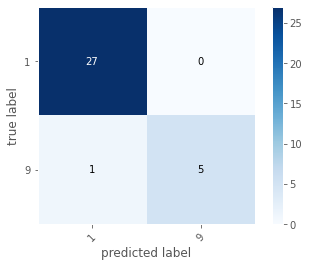

In [20]:
class_names = ['1', '9']
fig, ax = plot_confusion_matrix(conf_mat=final_ave_ConfusionMatrix,
                                colorbar=True,
                                #show_absolute=False,
                                #show_normed=True,
                                class_names=class_names)
plt.show()

In [21]:
final_ave_ReportMatrix=np.round (np.average(report_matrix_ave_collect,axis=0),decimals=3)
print("Report Matrix\n",final_ave_ReportMatrix)

Report Matrix
 [[ 0.975  0.995  0.984 26.87 ]
 [ 0.979  0.893  0.926  6.13 ]
 [   nan    nan  0.975 33.   ]
 [ 0.977  0.944  0.956 33.   ]
 [ 0.976  0.975  0.974 33.   ]]


## 4.3 Improt preprocessed results (importance)

In [22]:
path_preprocessed_results="./RF_results/MNIST19_preprocessed_results_2L.csv"
preprocessed_results=np.array(pd.read_csv(path_preprocessed_results,header=None))
preprocessed_results.shape

(100, 784)

## 4.4 Compute the important features for each undersampling

In [23]:
groups=4
top_select=150

In [24]:
print("preprocessed_results.shape[0]",preprocessed_results.shape,"\n")

group_importance=[]
selected_feature_indices=[]

memebers=int(preprocessed_results.shape[0]/float(groups))
for group_i in np.arange(groups):
    group_importance_i=np.sum(preprocessed_results[group_i*memebers:(group_i+1)*memebers,:],axis=0)
    indices_i=np.argsort(group_importance_i)[::-1][0:top_select]
    
    group_importance.append(group_importance_i)
    selected_feature_indices.append(indices_i)

preprocessed_results.shape[0] (100, 784) 



The number of group 0


./Defined/Functions.py:107: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  plt.tight_layout(p_pad,p_w_pad, p_h_pad)


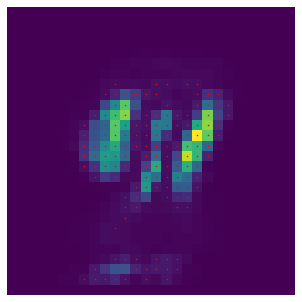

The number of group 1


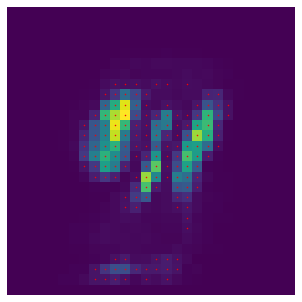

The number of group 2


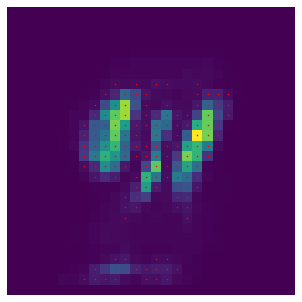

The number of group 3


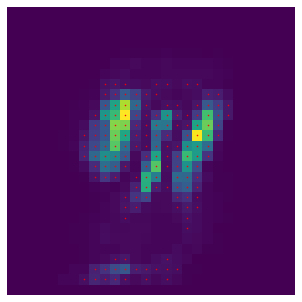

In [25]:
for group_i in np.arange(groups):
    print("The number of group",group_i)
    F.draw_with_importance(group_importance[group_i],original_edge_width,original_edge_length,top_select)

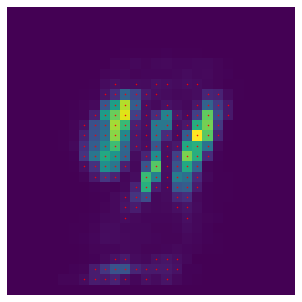

In [26]:
F.draw_with_importance(np.mean(group_importance,axis=0),original_edge_width,original_edge_length,top_select)

## 4.5 Compute the common important features from each undersampling

In [27]:
interect_indices=F.intersect_2Dlist(selected_feature_indices)
background=np.zeros(original_edge_length*original_edge_width)
background[F.intersect_2Dlist(selected_feature_indices)]=group_importance[0][interect_indices]

The number of group 0


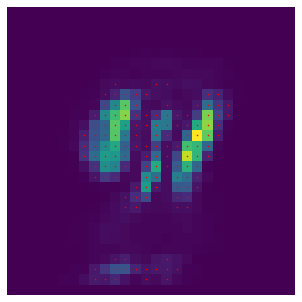

The number of group 1


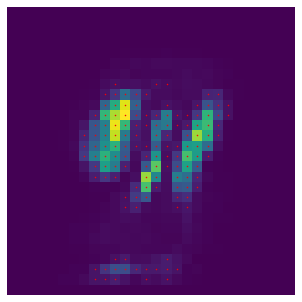

The number of group 2


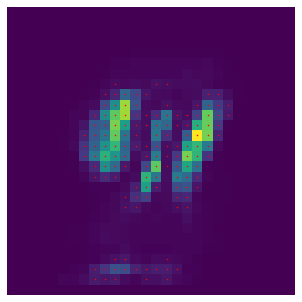

The number of group 3


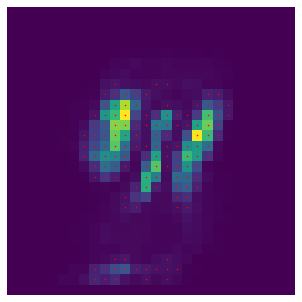

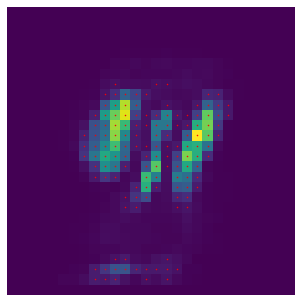

In [28]:
common_feature_catch=[]
for interect_indices_i in interect_indices:
    common_feature_catch.append([int(interect_indices_i/(original_edge_length)),interect_indices_i%(original_edge_length)])

for group_i in np.arange(groups):
    print("The number of group",group_i)
    F.show_one_figure_with_keyfeature(group_importance[group_i],common_feature_catch,original_edge_width,original_edge_length)

F.show_one_figure_with_keyfeature(np.average(np.array(group_importance),axis=0),common_feature_catch,original_edge_width,original_edge_length)

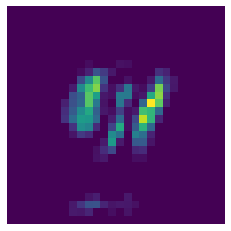

In [29]:
plt.imshow(background.reshape(original_edge_width,original_edge_length))
plt.axis('off')
plt.show()

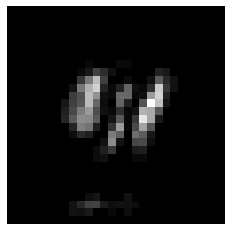

In [30]:
plt.imshow(background.reshape(original_edge_width,original_edge_length),plt.cm.gray)
plt.axis('off')
plt.show()